# Решение второй задачи по ОММ

## Аналитическое решение
Рассмотрим уравнение теплопроводности в прямоугольнике:

$$
\begin{equation*}
 \begin{cases}
   \frac{\partial u}{\partial t} = \Delta u, 0 < x < 1, 0 < y < 2, t > 0
   \\
   u(0, y, t) = 0
   \\
   u(1, y, t) = 0
   \\
   u(x, 0, t) = 0
   \\
   u(x, 2, t) = 0
   \\
   u(x, y, 0) = sin(2\pi x)sin(\pi y) = u_0(x, y)
 \end{cases}
\end{equation*}
$$

Ищем решение в виде разложения по собственным функциям задачи Штурма-Лиувилля в прямоугольнике:

$$
u(x, y, t) = \sum_{n = 1}^{\infty} \sum_{m = 1}^{\infty} T_{nm}(t)V_{nm}(x, y)
$$

СФ и СЗ задачи Ш-Л в прямоугольнике известны:

In [ ]:
$$
V_{nm}(x, y) = sin(\pi n x) sin(\frac{\pi m y}{2}), n, m \geqslant 1
$$

$$
\lambda_{nm} = (\pi n)^2 + (\frac{\pi m}{2})^2
$$

Неоднородность в уравнении и ГУ равны 0, а НУ представляет из себя СФ ЗШЛ с номерами n = 2, m = 2. Следовательно, ненулевыми членами в разложении будет только член с n = 2, m = 2. Подставив $u(x, y, t) = T_{22}(t) V_{22}(x, y)$ в уравнение, для $T_{22}(t)$ получаем задачу Коши:

$$
\begin{equation*}
    \begin{cases}
    T_{22}'(t) + 5 \pi ^2 T_{22}(t) = 0
    \\
    T_{22}(0) = 1
    \end{cases}
\end{equation*}
$$

$$
T_{22}(t) = e^{-5 \pi ^2 t}
$$

Аналитическое решение задачи:

$$
u(x, y, t) = sin(2 \pi x) sin(\pi y) e^{-5 \pi ^2 t}
$$

## Численное решение

"""
solution of thermal conductivity equation:
du/dt = delta(u), 0 < x < 1, 0 < y < 2, 0 < t <= T

with Dirichlet boundary conditions:
u(0, y, t) = 0
u(1, y, t) = 0
u(x, 0, t) = 0
u(x, 2, t) = 0

and initial condition:
u(x, y, 0) = sin(2 * pi * x) * sin(pi * y) = u0(x)
"""

import numpy as np
from numpy import pi, exp, sin, cos, sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# set equation parameters
Lx = 1.
Ly = 2.
T = 0.1

N = 50  # number of X intervals
M = 50  # number of Y intervals
J = 50  # number of time intervals

hx = Lx / N  # grid step that gives O(hx ** 2) error for Neumann boundary condition
hy = Ly / M
tau = T / J

gamma_x = tau / hx ** 2
gamma_y = tau / hy ** 2

x = np.linspace(0, Lx, N + 1)
y = np.linspace(0, Ly, M + 1)
t = np.linspace(0, T, J + 1)

xmesh2d, ymesh2d = np.meshgrid(x, y, indexing='ij')
tmesh3d, xmesh3d, ymesh3d = np.meshgrid(t, x, y, indexing='ij')


def analytical_solution(x, y, t):
    return sin(2 * pi * x) * sin(pi * y) * exp(-5 * pi ** 2 * t)


def u0(x, y):
    # initial condition
    return sin(2 * pi * x) * sin(pi * y)


def tridiag_mat_solver(A, F):
    # solve AY = -F, where A, Y, F - np.arrays, A - tridiagonal matrix

    n = len(F) - 1

    alpha = np.zeros(n + 1)
    beta = np.zeros(n + 1)

    a = np.zeros(n + 1)
    a[0] = 0
    for i in range(1, n + 1):
        a[i] = A[i, i - 1]
    b = np.zeros(n + 1)
    b[n] = 0
    for i in range(n):
        b[i] = A[i, i + 1]
    c = np.zeros(n + 1)
    for i in range(n + 1):
        c[i] = -A[i, i]

    alpha[0] = b[0] / c[0]
    beta[0] = F[0] / c[0]
    for i in range(1, n):
        alpha[i] = b[i] / (c[i] - a[i] * alpha[i - 1])
        beta[i] = (a[i] * beta[i - 1] + F[i]) / (c[i] - a[i] * alpha[i - 1])

    y = np.zeros(n + 1)
    y[n] = (F[n] + a[n] * beta[n - 1]) / (c[n] - a[n] * alpha[n - 1])
    for i in range(n - 1, -1, -1):
        y[i] = alpha[i] * y[i + 1] + beta[i]
    return y


def solve():
    w = np.zeros((2 * J + 1, N + 1, M + 1))

    # initial condition
    w[0, :, :] = u0(xmesh2d, ymesh2d)

    for j in range(0, 2 * J, 2):

        # from j to j + 1 / 2 -> solve system of N + 1 equations
        for m in range(1, M):
            A = np.zeros((N + 1, N + 1))
            F = np.zeros(N + 1)
            for n in range(1, N):
                A[n, n] = -(gamma_x + 1)
                A[n, n - 1] = 0.5 * gamma_x
                A[n, n + 1] = A[n, n - 1]
                F[n] = w[j, n, m] + 0.5 * gamma_y * (w[j, n, m + 1] - 2 * w[j, n, m] + w[j, n, m - 1])
            A[0, 0] = -1
            F[0] = 0  # boundary conditions
            A[-1, -1] = -1
            F[-1] = 0  # boundary conditions

            w[j + 1, :, m] = tridiag_mat_solver(A, F)

        # from j + 1 / 2 to j + 1 -> solve system of M + 1 equations
        for n in range(1, N):
            A = np.zeros((M + 1, M + 1))
            F = np.zeros(M + 1)
            for m in range(1, M):
                A[m, m] = -(gamma_y + 1)
                A[m, m - 1] = 0.5 * gamma_y
                A[m, m + 1] = A[m, m - 1]
                F[m] = w[j+1, n, m] + 0.5 * gamma_x * (w[j+1, n+1, m] - 2 * w[j+1, n, m] + w[j+1, n-1, m])
            A[0, 0] = -1
            F[0] = 0  # boundary conditions
            A[-1, -1] = -1
            F[-1] = 0  # boundary conditions

            w[j + 2, n, :] = tridiag_mat_solver(A, F)

        w[j + 2, 0, :] = 0
        w[j + 2, -1, :] = 0

    return w


def surf(ax, xmesh, ymesh, z, zlabel='', title=''):
    ax.plot_surface(xmesh, ymesh, z, cmap='winter', edgecolor='None')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(zlabel)
    ax.set_title(title)


w = solve()[::2, :, :]

u = analytical_solution(xmesh3d, ymesh3d, tmesh3d)
err = u - w


$$
u(x, y, t) = sin(2 \pi x) sin(\pi y) e^{-5 \pi ^2 t}
$$

## Численное решение

In [1]:
"""
solution of thermal conductivity equation:
du/dt = delta(u), 0 < x < 1, 0 < y < 2, 0 < t <= T

with Dirichlet boundary conditions:
u(0, y, t) = 0
u(1, y, t) = 0
u(x, 0, t) = 0
u(x, 2, t) = 0

and initial condition:
u(x, y, 0) = sin(2 * pi * x) * sin(pi * y) = u0(x)
"""

import numpy as np
from numpy import pi, exp, sin, cos, sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# set equation parameters
Lx = 1.
Ly = 2.
T = 0.1

N = 50  # number of X intervals
M = 50  # number of Y intervals
J = 50  # number of time intervals

hx = Lx / N  # grid step that gives O(hx ** 2) error for Neumann boundary condition
hy = Ly / M
tau = T / J

gamma_x = tau / hx ** 2
gamma_y = tau / hy ** 2

x = np.linspace(0, Lx, N + 1)
y = np.linspace(0, Ly, M + 1)
t = np.linspace(0, T, J + 1)

xmesh2d, ymesh2d = np.meshgrid(x, y, indexing='ij')
tmesh3d, xmesh3d, ymesh3d = np.meshgrid(t, x, y, indexing='ij')


def analytical_solution(x, y, t):
    return sin(2 * pi * x) * sin(pi * y) * exp(-5 * pi ** 2 * t)


def u0(x, y):
    # initial condition
    return sin(2 * pi * x) * sin(pi * y)


def tridiag_mat_solver(A, F):
    # solve AY = -F, where A, Y, F - np.arrays, A - tridiagonal matrix

    n = len(F) - 1

    alpha = np.zeros(n + 1)
    beta = np.zeros(n + 1)

    a = np.zeros(n + 1)
    a[0] = 0
    for i in range(1, n + 1):
        a[i] = A[i, i - 1]
    b = np.zeros(n + 1)
    b[n] = 0
    for i in range(n):
        b[i] = A[i, i + 1]
    c = np.zeros(n + 1)
    for i in range(n + 1):
        c[i] = -A[i, i]

    alpha[0] = b[0] / c[0]
    beta[0] = F[0] / c[0]
    for i in range(1, n):
        alpha[i] = b[i] / (c[i] - a[i] * alpha[i - 1])
        beta[i] = (a[i] * beta[i - 1] + F[i]) / (c[i] - a[i] * alpha[i - 1])

    y = np.zeros(n + 1)
    y[n] = (F[n] + a[n] * beta[n - 1]) / (c[n] - a[n] * alpha[n - 1])
    for i in range(n - 1, -1, -1):
        y[i] = alpha[i] * y[i + 1] + beta[i]
    return y


def solve():
    w = np.zeros((2 * J + 1, N + 1, M + 1))

    # initial condition
    w[0, :, :] = u0(xmesh2d, ymesh2d)

    for j in range(0, 2 * J, 2):

        # from j to j + 1 / 2 -> solve system of N + 1 equations
        for m in range(1, M):
            A = np.zeros((N + 1, N + 1))
            F = np.zeros(N + 1)
            for n in range(1, N):
                A[n, n] = -(gamma_x + 1)
                A[n, n - 1] = 0.5 * gamma_x
                A[n, n + 1] = A[n, n - 1]
                F[n] = w[j, n, m] + 0.5 * gamma_y * (w[j, n, m + 1] - 2 * w[j, n, m] + w[j, n, m - 1])
            A[0, 0] = -1
            F[0] = 0  # boundary conditions
            A[-1, -1] = -1
            F[-1] = 0  # boundary conditions

            w[j + 1, :, m] = tridiag_mat_solver(A, F)

        # from j + 1 / 2 to j + 1 -> solve system of M + 1 equations
        for n in range(1, N):
            A = np.zeros((M + 1, M + 1))
            F = np.zeros(M + 1)
            for m in range(1, M):
                A[m, m] = -(gamma_y + 1)
                A[m, m - 1] = 0.5 * gamma_y
                A[m, m + 1] = A[m, m - 1]
                F[m] = w[j+1, n, m] + 0.5 * gamma_x * (w[j+1, n+1, m] - 2 * w[j+1, n, m] + w[j+1, n-1, m])
            A[0, 0] = -1
            F[0] = 0  # boundary conditions
            A[-1, -1] = -1
            F[-1] = 0  # boundary conditions

            w[j + 2, n, :] = tridiag_mat_solver(A, F)

        w[j + 2, 0, :] = 0
        w[j + 2, -1, :] = 0

    return w


def surf(ax, xmesh, ymesh, z, zlabel='', title=''):
    ax.plot_surface(xmesh, ymesh, z, cmap='winter', edgecolor='None')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(zlabel)
    ax.set_title(title)


w = solve()[::2, :, :]

u = analytical_solution(xmesh3d, ymesh3d, tmesh3d)
err = u - w


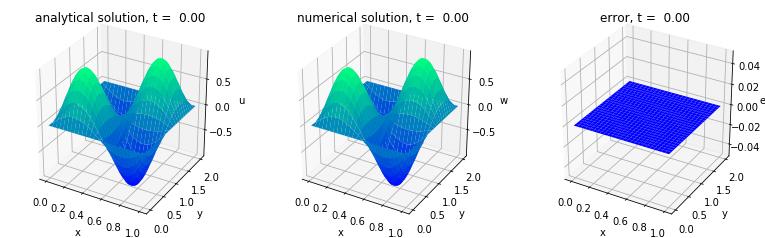

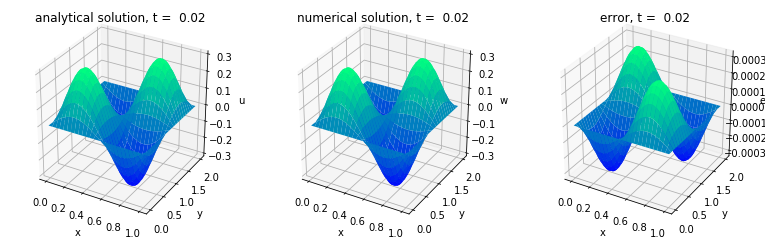

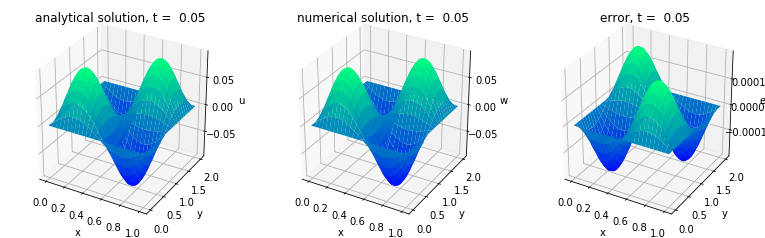

In [ ]:
for j in range(0, J + 1, int(J / 4)):
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    ax = fig.add_subplot(131, projection='3d')
    surf(ax, xmesh2d, ymesh2d, u[j, :, :], 'u', 'analytical solution, t = {0:5.2f}'.format(t[j]))
    ax = fig.add_subplot(132, projection='3d')
    surf(ax, xmesh2d, ymesh2d, w[j, :, :], 'w', 'numerical solution, t = {0:5.2f}'.format(t[j]))
    ax = fig.add_subplot(133, projection='3d')
    surf(ax, xmesh2d, ymesh2d, err[j, :, :], 'err', 'error, t = {0:5.2f}'.format(t[j]))
    plt.show()
    